# Post Alpha Discovery Sizing Strategy

In [12]:
import polars as pl 
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from pathlib import Path
from sklearn.decomposition import PCA
sns.set_theme(style="whitegrid")
COL_DATE='tradingDay'

In [4]:
script_dir = Path(Path.cwd()).parent
df = pl.read_parquet(script_dir / 'data' / 'synthetic_prices.parquet')
df = df.filter(pl.col('tradingDay') > datetime.date(2015,12,31))
df = df.group_by("tradingDay").first().sort("tradingDay")
df_ret = pl.read_parquet(script_dir / 'data' / 'df_ret.parquet')
df_w = pl.read_parquet(script_dir / 'data' / 'df_w.parquet')
df_w2 = pl.read_parquet(script_dir / 'data' / 'df_w2.parquet')
df_attr = pl.read_parquet(script_dir / 'data' / 'df_attr.parquet')
daily_pnl = pl.read_parquet(script_dir / 'data' / 'daily_pnl.parquet')
diag = pd.read_parquet(script_dir / 'data' / 'diag.parquet')
daily_xs = pl.read_parquet(script_dir / 'data' / 'daily_xs.parquet')
df_sig_rot = pl.read_parquet(script_dir / 'data' / 'df_sig_rot.parquet')
df_sig_cvol = pl.read_parquet(script_dir / 'data' / 'df_sig_cvol.parquet')
df_sig_vix = pl.read_parquet(script_dir / 'data' / 'df_sig_vix.parquet')

## Strategy Sizing Playbook
Position sizing is state-dependent and multiplicative.
Exposure is increased when structural edge conditions are present and reduced when they are not.
There are no hard on/off switches in the current implementation.

| Driver                                   | Structural Question It Answers                        | States Used                    | Multiplier Logic             | Practical Effect on Size                                                                |
| ---------------------------------------- | ----------------------------------------------------- | ------------------------------ | ---------------------------- | --------------------------------------------------------------------------------------- |
| **PCA Rotation**                         | Is the term-structure risk regime actively repricing? | STABLE / TRANSITION / UNSTABLE | 0.50 / 1.00 / 1.25           | Upsizes in high-rotation regimes where empirical edge is strongest                      |
| **PC1 Explained Variance**               | Is this a relative-value trade or a beta trade?       | MULTI_DIM / ONE_DIM            | 1.20 / 0.75                  | Prefers multi-factor RV environments; de-emphasizes beta-dominated regimes              |
| **Cross-Sectional Dispersion (`std_r`)** | Is the curve coherent or fragmented?                  | 5 dispersion buckets           | U-shaped (↓ middle, ↑ tails) | Avoids mediocre/noisy regimes; concentrates exposure where dispersion historically pays |
| **VIX Level**                            | Is volatility providing compensation for risk?        | LOW / HIGH                     | 0.50 / 1.25                  | Favors higher-volatility regimes where carry/curvature edge is stronger                 |
| **Global Boost**                         | How much capital do I want deployed on average?       | Scalar                         | Calibrated ex-post           | Controls mean exposure without changing relative state ranking                          |



## State Matrix based on Decile Analysis

In [5]:
state_pca = (
    df_sig_rot
    .select(["tradingDay", "rotation", "pc1_var"])
    .rename({'rotation':'pca_rotation'})
    .with_columns([
        pl.col("pca_rotation")
          .qcut(3, labels=["STABLE", "TRANSITION", "UNSTABLE"])
          .alias("pca_rotation_state"),

        pl.col("pc1_var")
          .qcut(2, labels=["MULTI_DIM", "ONE_DIM"])
          .alias("pc1_var_state"),
    ])
)

state_disp = (
    daily_xs
    .select(["tradingDay", "std_r", "max_abs_r"])
    .with_columns([
        pl.col("std_r")
          .qcut(5, labels=["LOW_DISPERSION", "LOWMID_DISPERSION", "MID_DISPERSION", "HIGHMID_DISPERSION", "HIGH_DISPERSION"])
          .alias("std_r_state"),

        pl.col("max_abs_r")
          .qcut(3, labels=["NORMAL", "STRESSED", "SHOCK"])
          .alias("max_abs_r_state"),
    ])
)

state_carry = (
    df_sig_cvol
    .with_columns(
        pl.col("port_carry").diff().alias("d_carry")
    )
    .select(["tradingDay", "port_carry", "d_carry", "carry_vol"])
    .with_columns([
        pl.col("port_carry")
          .qcut(3, labels=["LOW", "MID", "HIGH"])
          .alias("carry_state"),

        pl.col("d_carry")
          .qcut(3, labels=["FALL", "FLAT", "RISE"])
          .alias("d_carry_state"),

        pl.col("carry_vol")
          .qcut(3, labels=["STABLE", "MIXED", "UNSTABLE"])
          .alias("carry_vol_state"),
    ])
)

state_vix = (
    df_sig_vix
    .select(["tradingDay", "VIX"])
    .sort("tradingDay")
    .with_columns([
        pl.col("VIX").diff().alias("dVIX"),
    ])
    .drop_nulls(["VIX", "dVIX"])
    .with_columns([
        pl.col("VIX")
          .qcut(2, labels=["LOW", "HIGH"])
          .alias("VIX_state"),
        pl.col("dVIX")
          .qcut(3, labels=["DOWN", "FLAT", "UP"])
          .alias("dVIX_state"),
    ])
    .select([COL_DATE, "VIX", "dVIX", "VIX_state", "dVIX_state"])
)
state_matrix = (
    state_pca
    .join(state_disp, on="tradingDay", how="inner")
    .join(state_carry, on="tradingDay", how="inner")
    .join(state_vix, on="tradingDay", how="left")  # contextual
    .sort("tradingDay")
)


In [6]:
for c in ["pca_rotation_state", "pc1_var_state", "std_r_state", "max_abs_r_state", "VIX_state", "dVIX_state"]:
    if c in state_matrix.columns:
        print(c)
        display(state_matrix.group_by(c).agg(pl.len().alias("n_days")).sort(c))


pca_rotation_state


pca_rotation_state,n_days
cat,u32
"""STABLE""",160
"""TRANSITION""",157
"""UNSTABLE""",159


pc1_var_state


pc1_var_state,n_days
cat,u32
"""MULTI_DIM""",240
"""ONE_DIM""",236


std_r_state


std_r_state,n_days
cat,u32
"""LOW_DISPERSION""",99
"""LOWMID_DISPERSION""",99
"""MID_DISPERSION""",99
"""HIGHMID_DISPERSION""",96
"""HIGH_DISPERSION""",83


max_abs_r_state


max_abs_r_state,n_days
cat,u32
"""NORMAL""",168
"""STRESSED""",164
"""SHOCK""",144


VIX_state


VIX_state,n_days
cat,u32
"""LOW""",236
"""HIGH""",240


dVIX_state


dVIX_state,n_days
cat,u32
"""DOWN""",154
"""FLAT""",162
"""UP""",160


## State Matrix — Interpretation → Sizing Action

$$\text{scale}_t=\text{base} \times \text{global boost}  \times \Pi_i \cdot m_i \cdot\left(state_{i,t}\right)$$

| Signal                                   | State                  | Empirical Interpretation (from analysis)                  | Multiplier | Sizing Action |
| ---------------------------------------- | ---------------------- | --------------------------------------------------------- | ---------: | ------------- |
| **PCA Rotation**                         | **STABLE**             | Low eigenvector movement; quieter regime with weaker edge |   **0.80** | Decrease      |
|                                          | **TRANSITION**         | Moderate rotation; baseline edge                          |   **1.10** | Neutral       |
|                                          | **UNSTABLE**           | High rotation; regime repricing where edge is strongest   |   **1.10** | Increase      |
|                                          |                        |                                                           |            |               |
| **PC1 Explained Variance**               | **MULTI_DIM**          | Risk spread across factors; RV-friendly environment       |   **1.15** | Increase      |
|                                          | **ONE_DIM**            | PC1 dominates; strategy behaves more like beta            |   **0.75** | Decrease      |
|                                          |                        |                                                           |            |               |
| **Cross-Sectional Dispersion (`std_r`)** | **LOW_DISPERSION**     | Very coherent curve; clean relative-value behavior        |    **0.80** | Decrease      |
|                                          | **LOWMID_DISPERSION**  | Mild fragmentation; weak or noisy edge                    |   **0.90** | Decrease      |
|                                          | **MID_DISPERSION**     | Typical dispersion; still low-quality edge                |   **1.00** | Neutral     |
|                                          | **HIGHMID_DISPERSION** | Elevated dispersion; edge re-emerges                      |   **1.10** | Increase      |
|                                          | **HIGH_DISPERSION**    | Very high dispersion; strong but riskier edge             |   **1.20** | Increase      |
|                                          |                        |                                                           |            |               |
| **VIX Level**                            | **LOW**                | Low-vol regime; weaker structural edge                    |   **0.70** | Decrease      |
|                                          | **HIGH**               | High-vol regime; edge materially stronger                 |   **1.30** | Increase      |



In [7]:
STATE_MULT = {
    "pca_rotation_state": {
        "STABLE": 0.8,
        "TRANSITION": 1.1,
        "UNSTABLE": 1.1,  
    },
    "pc1_var_state": {
        "MULTI_DIM": 1.15,
        "ONE_DIM": 0.75,
    },
    "std_r_state": {
        "LOW_DISPERSION": 0.8,
        "LOWMID_DISPERSION": 0.9,
        "MID_DISPERSION": 1.0,   
        "HIGHMID_DISPERSION": 1.1,
        "HIGH_DISPERSION": 1.2,
    },
    
    "VIX_state": {
        "LOW": 0.7,
        "HIGH": 1.3,
    },

}

STATE_COLS = list(STATE_MULT.keys())



def add_state_sizing(
    state_matrix: pl.DataFrame,
    ret_col: str = "forward_ret",  # or "strategy_ret" depending on your frame
    base_exposure: float = 1.0,
    global_boost: float = 1.0,     # <- your main tuning knob
    cap: float = 3.0,
    floor: float = 0.0,
) -> pl.DataFrame:
    """
    Adds:
      - per-signal multiplier columns (m_<signal>)
      - raw_scale = base_exposure * global_boost * Π multipliers
      - scale = clipped raw_scale
      - sized_return = scale * return
    """

    df = state_matrix

    # Build per-signal multiplier expressions
    mult_exprs = []
    mult_cols = []
    for col in STATE_COLS:
        mapping = STATE_MULT[col]
        mcol = f"m_{col}"
        mult_cols.append(mcol)

        # map_dict returns null if key missing -> fill to 1.0 to avoid blowing up
        expr = (
            pl.col(col)
            .cast(pl.Utf8)
            .replace(mapping, default=1.0)
            .fill_null(1.0)
            .alias(mcol)
        )
        mult_exprs.append(expr)

    df = df.with_columns(mult_exprs)

    # Multiply all multipliers together (product)
    prod_expr = None
    for mcol in mult_cols:
        prod_expr = pl.col(mcol) if prod_expr is None else (prod_expr * pl.col(mcol))

    df = df.with_columns(
        (pl.lit(base_exposure) * pl.lit(global_boost) * prod_expr).fill_null(base_exposure * global_boost).alias("raw_scale")).with_columns(
        pl.col("raw_scale").clip(floor, cap).alias("scale"),
    )

    if ret_col in df.columns:
        df = df.with_columns([
            (pl.col("scale") * pl.col(ret_col)).alias("sized_ret")
        ])

    return df



def calibrate_global_boost_to_target_mean_exposure(
    state_matrix: pl.DataFrame,
    target_mean_exposure: float = 1.0,
    base_exposure: float = 1.0,
    cap: float = 3.0,
    floor: float = 0.0,
) -> float:
    """
    Computes a global_boost that makes E[scale] ~ target_mean_exposure
    *before* clipping dominates. This keeps the logic intact and only rescales.
    """
    # compute unboosted product scale (global_boost = 1)
    tmp = add_state_sizing(
        state_matrix,
        ret_col="__none__",  # won't be used
        base_exposure=base_exposure,
        global_boost=1.0,
        cap=1e9,             # avoid clip here
        floor=0.0,
    )

    mean_unclipped = tmp.select(pl.col("raw_scale").mean()).item()

    if mean_unclipped is None or mean_unclipped == 0:
        return 1.0

    return float(target_mean_exposure / mean_unclipped)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [8]:
# 1) Compute a global boost that targets average exposure = 1.25 (example)
gb = calibrate_global_boost_to_target_mean_exposure(
    state_matrix,
    target_mean_exposure=1.25,
    base_exposure=1.0,
)
# 2) Apply sizing
state_sized = add_state_sizing(
    state_matrix,
    ret_col="forward_ret",
    base_exposure=1.0,
    global_boost=1.0,
    cap=2.0,
    floor=0.0,
)

# 3) Quick sanity
state_sized.select([
    pl.col("scale").mean().alias("avg_scale"),
    pl.col("scale").quantile(0.5).alias("med_scale"),
    pl.col("scale").quantile(0.95).alias("p95_scale"),
    pl.col("scale").max().alias("max_scale"),
]).to_pandas()


/tmp/ipykernel_1252599/1367888108.py:58: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  pl.col(col)


,avg_scale,med_scale,p95_scale,max_scale
0,0.955489,0.858,1.9734,1.9734


In [9]:
gb

1.3082304072982986

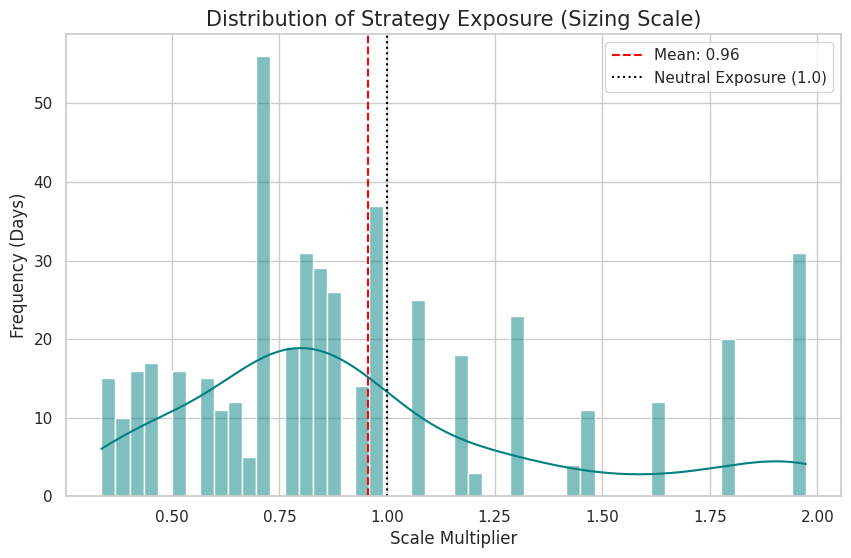

In [13]:
plt.figure(figsize=(10, 6))

# Create the histogram
sns.histplot(
    state_sized["scale"].to_pandas(), 
    bins=50, 
    kde=True, 
    color="teal",
    edgecolor="white"
)

# Add vertical lines for context
plt.axvline(state_sized["scale"].mean(), color="red", linestyle="--", label=f"Mean: {state_sized['scale'].mean():.2f}")
plt.axvline(1.0, color="black", linestyle=":", label="Neutral Exposure (1.0)")

# Aesthetics
plt.title("Distribution of Strategy Exposure (Sizing Scale)", fontsize=15)
plt.xlabel("Scale Multiplier", fontsize=12)
plt.ylabel("Frequency (Days)", fontsize=12)
plt.legend()

plt.show()

In [14]:
daily_pnl.with_columns(pl.col('strategy_ret').shift(-1).alias('forward_ret'))

tradingDay,strategy_ret,forward_ret
date,f64,f64
2016-05-13,-0.004403,0.012133
2016-05-16,0.012133,0.00218
2016-05-17,0.00218,0.00669
2016-05-18,0.00669,0.007617
2016-05-19,0.007617,-0.003219
…,…,…
2025-10-28,-0.004704,0.009102
2025-10-29,0.009102,0.011942
2025-10-30,0.011942,0.014958


In [15]:
strategy = (
    daily_pnl
    .with_columns(pl.col('strategy_ret').shift(-1).alias('forward_ret'))
    .join(state_sized, on='tradingDay', how='left')
        .fill_null(strategy='forward')
    .with_columns((pl.col('forward_ret') * pl.col('scale')).alias('sized_ret'))
    .drop_nulls()
)
strategy.head(10)

tradingDay,strategy_ret,forward_ret,pca_rotation,pc1_var,pca_rotation_state,pc1_var_state,std_r,max_abs_r,std_r_state,max_abs_r_state,port_carry,d_carry,carry_vol,carry_state,d_carry_state,carry_vol_state,VIX,dVIX,VIX_state,dVIX_state,m_pca_rotation_state,m_pc1_var_state,m_std_r_state,m_VIX_state,raw_scale,scale,sized_ret
date,f64,f64,f64,f64,cat,cat,f64,f64,cat,cat,f64,f64,f64,cat,cat,cat,f32,f32,cat,cat,f64,f64,f64,f64,f64,f64,f64
2016-06-20,-0.017342,-0.030711,0.00038,0.982268,"""STABLE""","""ONE_DIM""",0.005477,0.008381,"""LOWMID_DISPERSION""","""NORMAL""",0.00114,0.000887,0.001019,"""MID""","""RISE""","""UNSTABLE""",18.200001,-0.929998,"""HIGH""","""DOWN""",0.8,0.75,0.9,1.3,0.702,0.702,-0.021559
2016-06-21,-0.030711,0.025707,0.00038,0.982268,"""STABLE""","""ONE_DIM""",0.005477,0.008381,"""LOWMID_DISPERSION""","""NORMAL""",0.00114,0.000887,0.001019,"""MID""","""RISE""","""UNSTABLE""",18.200001,-0.929998,"""HIGH""","""DOWN""",0.8,0.75,0.9,1.3,0.702,0.702,0.018046
2016-06-22,0.025707,-0.046604,0.00038,0.982268,"""STABLE""","""ONE_DIM""",0.005477,0.008381,"""LOWMID_DISPERSION""","""NORMAL""",0.00114,0.000887,0.001019,"""MID""","""RISE""","""UNSTABLE""",18.200001,-0.929998,"""HIGH""","""DOWN""",0.8,0.75,0.9,1.3,0.702,0.702,-0.032716
2016-06-23,-0.046604,0.033856,0.00038,0.982268,"""STABLE""","""ONE_DIM""",0.005477,0.008381,"""LOWMID_DISPERSION""","""NORMAL""",0.00114,0.000887,0.001019,"""MID""","""RISE""","""UNSTABLE""",18.200001,-0.929998,"""HIGH""","""DOWN""",0.8,0.75,0.9,1.3,0.702,0.702,0.023767
2016-06-24,0.033856,0.01834,0.00038,0.982268,"""STABLE""","""ONE_DIM""",0.005477,0.008381,"""LOWMID_DISPERSION""","""NORMAL""",0.00114,0.000887,0.001019,"""MID""","""RISE""","""UNSTABLE""",18.200001,-0.929998,"""HIGH""","""DOWN""",0.8,0.75,0.9,1.3,0.702,0.702,0.012875
2016-06-27,0.01834,0.0025,0.001027,0.983103,"""TRANSITION""","""ONE_DIM""",0.035301,0.128662,"""HIGH_DISPERSION""","""SHOCK""",-0.000451,0.000534,0.001218,"""LOW""","""RISE""","""UNSTABLE""",23.219999,-1.27,"""HIGH""","""DOWN""",1.1,0.75,1.2,1.3,1.287,1.287,0.003218
2016-06-28,0.0025,0.016666,0.001027,0.983103,"""TRANSITION""","""ONE_DIM""",0.035301,0.128662,"""HIGH_DISPERSION""","""SHOCK""",-0.000451,0.000534,0.001218,"""LOW""","""RISE""","""UNSTABLE""",23.219999,-1.27,"""HIGH""","""DOWN""",1.1,0.75,1.2,1.3,1.287,1.287,0.021449
2016-06-29,0.016666,0.022785,0.001027,0.983103,"""TRANSITION""","""ONE_DIM""",0.035301,0.128662,"""HIGH_DISPERSION""","""SHOCK""",-0.000451,0.000534,0.001218,"""LOW""","""RISE""","""UNSTABLE""",23.219999,-1.27,"""HIGH""","""DOWN""",1.1,0.75,1.2,1.3,1.287,1.287,0.029325
2016-06-30,0.022785,-0.004265,0.001027,0.983103,"""TRANSITION""","""ONE_DIM""",0.035301,0.128662,"""HIGH_DISPERSION""","""SHOCK""",-0.000451,0.000534,0.001218,"""LOW""","""RISE""","""UNSTABLE""",23.219999,-1.27,"""HIGH""","""DOWN""",1.1,0.75,1.2,1.3,1.287,1.287,-0.005488


In [16]:
strategy.write_parquet(script_dir / 'data' / 'strategy.parquet')